*Copyright (C) 2022 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Relational networks

This tutorial demonstrates how to set up a relational network with lava-dnf.

Relational networks are a network topology composed of DNFs that enables representing relational features, for example the difference/error between two represented values. In DFT, relational networks are one of the major building blocks of larger architectures, most often employed to implement coordinate transforms between different spaces (e.g., retinal vs. allocentric visual space).

![Diagram relational network](./diagram_relational_network.png)

The figure above illustrates the network topology. Two 1D DNFs, ‘target’ and ‘reference’, are input into a 2D-dimensional ‘transformation’ DNF that represents all possible combinations of the positions in the two DNFs. The 1D DNFs project into the ‘transformation’ DNF, forming subthreshold ridges of activation; only regions in which the ridges overlap form peaks. This activation projects along the diagonal onto the ‘relational’ DNF. The peaks that form there represent the peak-positions in the ‘target’ DNF relative to the position of the peak-position in the ‘reference’ DNF (center of the ‘relational’ DNF).
The diagram visualizes an example with one-dimensional input and output DNFs but the same concept can be applied to higher-dimensional input/output.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lava.proc.io.sink import RingBuffer
from lava.magma.core.run_configs import Loihi1SimCfg,Loihi2HwCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense
from lava.proc.monitor.process import Monitor
from lava.lib.dnf.connect.connect import connect
from lava.lib.dnf.inputs.gauss_pattern.process import GaussPattern
from lava.lib.dnf.inputs.rate_code_spike_gen.process import \
    RateCodeSpikeGen
from lava.lib.dnf.operations.operations import (
    Weights,
    ExpandDims,
    ReorderDims,
    ReduceAlongDiagonal,
    ExpandAlongDiagonal,
    Flip)

## Check whether Loihi 2 is available

In [2]:
from lava.utils.system import Loihi2
Loihi2.preferred_partition = 'oheogulch'
loihi2_is_available = Loihi2.is_loihi2_available

if loihi2_is_available:
    print(f'Running on {Loihi2.partition}')
    from lava.proc.embedded_io.spike import PyToNxAdapter, NxToPyAdapter
    from lava.lib.dnf.tutorials.relational_networks.c_reader import Reader
    
else:
    print("Loihi2 compiler is not available in this system. "
          "This tutorial will execute on CPU backend.")

Running on oheogulch


## Setting up and running the Relational Network
In lava-dnf, relational networks can be constructed from basic Lava Processes, like the LIF Processes, and connectivity structures that can be generated with the `connect` function from lava-dnf. The following example demonstrates a relational network with one-dimensional input. The Network below can either be run in simulation or on Loihi 2. 

In [3]:
shape = (15,)
shape_relational = tuple(np.array(shape) * 2 - 1)
num_time_steps = 100

# Set up Processes that provide Input to the Relational Network
gauss_target = GaussPattern(shape=shape, amplitude=5000, mean=8, stddev=0.1)
sg_target = RateCodeSpikeGen(shape=shape)

gauss_reference = GaussPattern(shape=shape, amplitude=5000, mean=5, stddev=0.1)
sg_reference = RateCodeSpikeGen(shape=shape)

input_dense_target = Dense(weights=np.eye(shape[0]) * 25)
input_dense_reference = Dense(weights=np.eye(shape[0]) * 25)

# Set up Processes that constitute the Relational Network
target = LIF(shape=shape, du=409, dv=2045, vth=200)
reference = LIF(shape=shape, du=409, dv=2045, vth=200)
transformation = LIF(shape=shape + shape, du=409, dv=2045, vth=200)
relational = LIF(shape=shape_relational, du=409, dv=2045, vth=200)

# Set up RingBuffer Processes to store Variable Evolutions/Spike Activity (later used for plotting)
py_rec_target = RingBuffer(shape=shape, buffer=num_time_steps)
py_rec_reference = RingBuffer(shape=shape, buffer=num_time_steps)
py_rec_relational = RingBuffer(shape=shape_relational, buffer=num_time_steps)
py_rec_transformation = RingBuffer(shape=shape+shape, buffer=num_time_steps)

# On Loihi 2 we additionally need CProcesses to bridge input from Python via LMT to the NeuroCore and back:
if loihi2_is_available:
    injector_target = PyToNxAdapter(shape=shape)
    injector_reference = PyToNxAdapter(shape=shape)
    spike_reader = Reader(shape_target=shape,
                          shape_reference=shape,
                          shape_relational=shape_relational,
                          shape_transformation=shape+shape)

# Make Connections
# Connect Gauss Pattern to Spike Generators
gauss_target.a_out.connect(sg_target.a_in)
gauss_reference.a_out.connect(sg_reference.a_in)

# On Loihi 2 the input needs to be sent via LMT to reach the corresponding dense processes.
# In Simulation we can directly connect the generated spike input to the corresponding dense processes.
if loihi2_is_available:
    sg_target.s_out.connect(injector_target.inp)
    sg_reference.s_out.connect(injector_reference.inp)
    injector_target.out.connect(input_dense_target.s_in)
    injector_reference.out.connect(input_dense_reference.s_in)
else:
    sg_target.s_out.connect(input_dense_target.s_in)
    sg_reference.s_out.connect(input_dense_reference.s_in)

input_dense_target.a_out.connect(target.a_in)
input_dense_reference.a_out.connect(reference.a_in)

# Make Relational Network Connections
connect(target.s_out, transformation.a_in,
        ops=[ExpandDims(new_dims_shape=shape[0]),
             Weights(10)])
connect(reference.s_out, transformation.a_in,
        ops=[Flip(),
             ExpandDims(new_dims_shape=shape[0]),
             ReorderDims(order=(1, 0)),
             Weights(10)])
weights_reduce_diag = connect(transformation.s_out, relational.a_in,
                              ops=[ReduceAlongDiagonal(), Weights(25)])
weights_expand_diag = connect(relational.s_out, transformation.a_in,
                              ops=[ExpandAlongDiagonal(), Weights(5)])

# On Loihi 2 spikes need to go via LMT from the NeuroCore to RingBuffers.
# For all LIF populations we want to read out spike rates. Except for the Transformation field,
# for which we later plot the voltage.
if loihi2_is_available:
    target.s_out.connect(spike_reader.in_target)
    relational.s_out.connect(spike_reader.in_relational)
    reference.s_out.connect(spike_reader.in_reference)
    spike_reader.ref_transformation.connect_var(transformation.v)

    spike_reader.out_target.connect(py_rec_target.a_in)
    spike_reader.out_relational.connect(py_rec_relational.a_in)
    spike_reader.out_transformation.connect(py_rec_transformation.a_in)
    spike_reader.out_reference.connect(py_rec_reference.a_in)
    
else:
    target.s_out.connect(py_rec_target.a_in)
    relational.s_out.connect(py_rec_relational.a_in)
    reference.s_out.connect(py_rec_reference.a_in)
    monitor_transformation = Monitor()
    monitor_transformation.probe(transformation.v, num_time_steps)

# Execution
if loihi2_is_available:
    run_cfg = Loihi2HwCfg()
else: 
    run_cfg=Loihi1SimCfg(select_tag="fixed_pt")
try:
    target.run(condition=RunSteps(num_steps=num_time_steps),
               run_cfg=run_cfg)

    # Extract data from RingBuffers
    data_target = py_rec_target.data.get().transpose()
    data_reference = py_rec_reference.data.get().transpose()
    data_relational = py_rec_relational.data.get().transpose()
    
    # Variable probing currently still works differently in simulation vs.on Loihi 2 Hardware
    if loihi2_is_available:
        data_transformation = py_rec_transformation.data.get().transpose()
    else:
         data_transformation = monitor_transformation.get_data() \
        [transformation.name][transformation.v.name].astype(float)

finally:
    target.stop()

Per core distribution:
----------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Cores |
|--------------------------------------------------------------|
|     225|       1|      29|    2025|      29|       0|       1|
|      59|       1|     225|    3127|     225|       0|       1|
|      15|       1|      15|      75|      15|       0|       1|
|      15|       1|      15|      75|      15|       0|       1|
|--------------------------------------------------------------|
| Total                                               |       4|
----------------------------------------------------------------


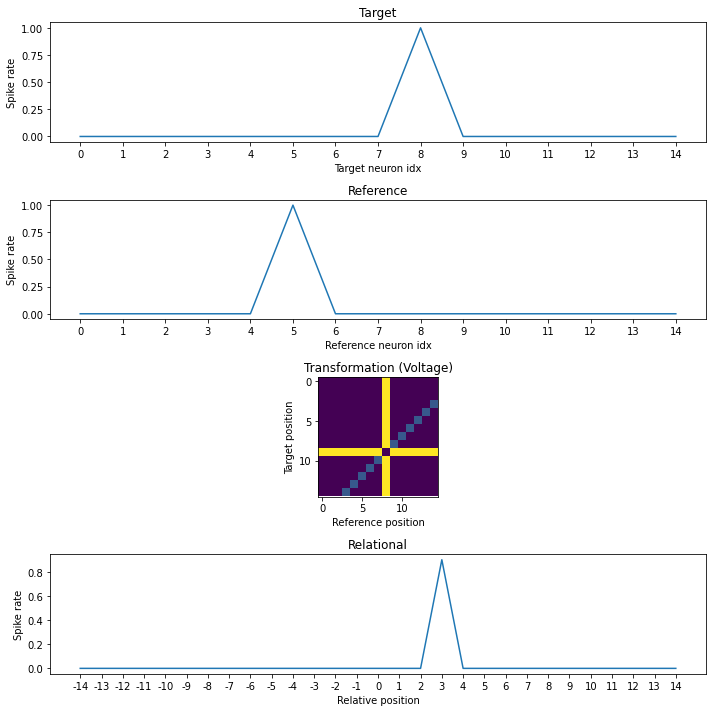

In [4]:
# Plot data
_num_neurons = shape[0]
_num_neurons_relational = shape_relational[0]

plt.figure(figsize=(10, 10))
ax0 = plt.subplot(4, 1, 1)
ax0.plot(np.mean(data_target[50:70, :], axis=0))
ax0.set_xlabel('Target neuron idx')
ax0.set_ylabel('Spike rate')
ax0.set_xticks(range(_num_neurons))
ax0.set_title('Target')

ax1 = plt.subplot(4, 1, 2)
ax1.plot(np.mean(data_reference[50:70, :], axis=0))
ax1.set_xlabel('Reference neuron idx')
ax1.set_ylabel('Spike rate')
ax1.set_xticks(range(_num_neurons))
ax1.set_title('Reference')

ax2 = plt.subplot(4, 1, 3)
ax2.imshow(np.mean(data_transformation[50:70, :],
                   axis=0).reshape(shape + shape))
ax2.set_title('Transformation (Voltage)')
ax2.set_xlabel('Reference position')
ax2.set_ylabel('Target position')
ax2.set_xticks(range(0, _num_neurons, 5))
ax2.set_yticks(range(0, _num_neurons, 5))

ax3 = plt.subplot(4, 1, 4)
ax3.plot(np.mean(data_relational[50:70], axis=0))
ax3.set_xlabel('Relative position')
ax3.set_ylabel('Spike rate')
ax3.set_title('Relational')
plt.xticks(ticks=range(_num_neurons_relational),
           labels=range(-int(_num_neurons_relational/2),
                        int(_num_neurons_relational/2) + 1))

plt.tight_layout()
plt.show()